In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt

select u from random distribution 0~1

In [2]:
from scipy.stats import truncnorm
# normal distribution 0~1
lower, upper = 0, 1
mu, sigma = 0.5, 0.2
distribution = truncnorm(
    (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)

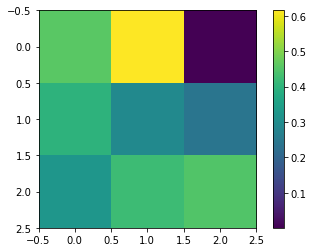

In [3]:
x = distribution.rvs((3,3),random_state=1)
plt.imshow(x)
plt.colorbar()
plt.show()
plt.close()

functions

In [4]:
def obj_func(b_Beta, multiplier, u, n):
    b = b_Beta[:n]
    Beta = b_Beta[n]
    q = np.sum(b, axis=1) # sum over j
    p = np.sum(b, axis=0) # sum over i
    m1 = multiplier[0]
    m2 = multiplier[1:n+1]
    m3 = multiplier[n+1]
    m4 = multiplier[n+2]
    m5 = multiplier[n+3:2*n+3]
    
    obj = np.sum(p * np.log((p/Beta).astype(np.float64))) - np.sum(b * np.log(u)) \
        + np.sum(m1 * (p - q)) + np.sum(m2 * (Beta.reshape((n,1)) - p/u)) \
        + np.sum(m3 * (1 - p)) + np.sum(m4 * (1 - q)) \
        + np.sum(m5 * (0 - b)) 

    return obj

def update_b_Beta(b_Beta, multiplier, u, grad_b_Beta_history, learning_rate, n):
   
    b = b_Beta[:n]
    Beta = b_Beta[n]
    q = np.sum(b, axis=1) # sum over j
    p = np.sum(b, axis=0) # sum over i
    m1 = multiplier[0]
    m2 = multiplier[1:n+1]
    m3 = multiplier[n+1]
    m4 = multiplier[n+2]
    m5 = multiplier[n+3:2*n+3]

    grad_b_term1 = np.array([[np.log(p[j]/Beta[j])+1 for j in range(n)] for i in range(n)] )
    grad_b_term2 = -np.log(u)
    grad_b_m1_term = np.array([[0.0]*n for i in range(n)])
    for i in range(n):
        for j in range(n):
            if i==j:
                grad_b_m1_term[i][j] = 0.0
            else:
                grad_b_m1_term[i][j] = m1[j]-m1[i]
    grad_b_m2_term = np.array([[np.sum([-m2[i][j]/u[i][j] for i in range(n)]) for j in range(n)] for row in range(n)])
    grad_b_m3_term = np.array([[-m3[j] for j in range(n)] for i in range(n)])
    grad_b_m4_term = np.array([[-m4[j] for j in range(n)] for i in range(n)]).T
    grad_b_m5_term = -m5 
    grad_Beta_term1 = np.array([[-p[j]/Beta[j] for j in range(n)]])
    grad_Beta_m2_term = np.array([[np.sum(m2,axis=1)[j] for j in range(n)]]) 

    grad_b = grad_b_term1 + grad_b_term2 + grad_b_m1_term + grad_b_m2_term + grad_b_m3_term + grad_b_m4_term + grad_b_m5_term
    grad_Beta = grad_Beta_term1 + grad_Beta_m2_term
    grad_b_Beta = np.concatenate((grad_b, grad_Beta), axis=0)

    learning_rate = learning_rate
    # GD
    b_Beta = b_Beta - learning_rate * grad_b_Beta

    grad_b_Beta_history.append(grad_b_Beta)
    
    return b_Beta


def calculate_p_q(b):
    q = np.sum(b, axis=1) # sum over j
    p = np.sum(b, axis=0) # sum over i
    
    return p, q
    
def update_multiplier(multiplier, b_Beta, u, grad_multiplier_history, learning_rate, n):
    b = b_Beta[:n]
    Beta = b_Beta[n]
    q = np.sum(b, axis=1) # sum over j
    p = np.sum(b, axis=0) # sum over i

    grad_m1 = (p - q).reshape((1,n))
    grad_m2 = Beta.reshape((n,1)) - p/u
    grad_m3 = (1 - p).reshape((1,n))
    grad_m4 = (1 - q).reshape((1,n))
    grad_m5 = 0 - b 
    grad_m1_m2_m3_m4_m5 = np.concatenate((grad_m1, grad_m2, grad_m3, grad_m4, grad_m5), axis=0)
    
    learning_rate = learning_rate
    # GA
    multiplier = multiplier + learning_rate * grad_m1_m2_m3_m4_m5
        
    grad_multiplier_history.append(grad_m1_m2_m3_m4_m5)

    multiplier[1:2*n+3] = np.where(multiplier[1:2*n+3]<0, 0, multiplier[1:2*n+3])

    return multiplier

main function

In [5]:
def start_experiment(T, learning_rate, u, n):
    '''
    Parameters
    ----------
        T: iterations
        learning_rate: stepsize
        u: (int)random_state, (ndarray)input array
        n: number of agents
    
    Return
    ------
        result: experiment results
    '''

    if type(u)==int:
        random_state = u
        u = distribution.rvs((n,n),random_state=random_state)
    elif type(u)==np.ndarray:
        random_state = 'given'
        u = u
    else:
        print('Not a valid input u')
        
    for t in range(T):
        if t==0:
            b = np.full((n,n),1/n)     
            q = np.sum(b, axis=1)
            p = np.sum(b, axis=0)
            q_history = [q]
            p_history = [p]

            Beta=np.full(n,1.0)
            
            b_Beta = np.concatenate((b, Beta.reshape((1,n))), axis=0)
            b_Beta_history = [b_Beta]
            
            multiplier = np.zeros((2*n+3,n))
            multiplier_history = [multiplier]

            obj = obj_func(b_Beta, multiplier, u, n)
            obj_history = [obj]
            avg_obj_history = [obj]
            
            max_obj_when_x_history = [obj]
            min_obj_when_y_history = []

            grad_b_Beta_history = [np.zeros((n+1,n))]
            grad_multiplier_history = [np.zeros((2*n+3,n))]
    
        else:
            b_Beta = update_b_Beta(b_Beta, multiplier, u, grad_b_Beta_history, learning_rate, n)
            b_Beta_history.append(b_Beta)
            
            b = b_Beta[:n]
            p, q = calculate_p_q(b)
            q_history.append(q)
            p_history.append(p)

            min_obj_when_y = obj_func(b_Beta, multiplier, u, n)
            min_obj_when_y_history.append(min_obj_when_y)

            multiplier = update_multiplier(multiplier, b_Beta, u, grad_multiplier_history, learning_rate, n)
            multiplier_history.append(multiplier)

            obj = obj_func(b_Beta, multiplier, u, n)
            obj_history.append(obj)

            max_obj_when_x_history.append(obj)

            avg_obj_history.append((avg_obj_history[-1] * len(avg_obj_history) + obj)/(len(avg_obj_history)+1))
    
    b_Beta = update_b_Beta(b_Beta, multiplier, u, grad_b_Beta_history, learning_rate, n)
    b_Beta_history.append(b_Beta)

    b = b_Beta[:n]
    p, q = calculate_p_q(b)
    q_history.append(q)
    p_history.append(p)

    min_obj_when_y = obj_func(b_Beta, multiplier, u, n)
    min_obj_when_y_history.append(min_obj_when_y)

    result = {
        'T': T,
        'lr': learning_rate,
        'n': n,
        'u': u,
        'random_state': random_state,
        'objective': obj_history[-1],
        'min_obj': np.min(obj_history),
        'obj_history': obj_history,
        'avg_obj_history': avg_obj_history,
        'b_Beta_history': b_Beta_history,
        'q_history': q_history,
        'p_history': p_history,
        'multiplier_history': multiplier_history,
        'grad_b_Beta_history': grad_b_Beta_history,
        'grad_multiplier_history': grad_multiplier_history,
        'max_obj_when_x_history': max_obj_when_x_history,
        'min_obj_when_y_history': min_obj_when_y_history
    }
    # save to pickle for reuse
    with open('experiment/Minimax_GDA/n_{}_u_{}_lr{}_iter{}.pickle'.format(n,random_state,learning_rate,T), 'wb') as f:
        pickle.dump(result, f)

    return result

draw plt functions

In [6]:
def draw_obj_plt(result, ylim):
    # plot obj curve
    T = result['T']
    learning_rate = result['lr']
    random_state = result['random_state']
    n = result['n']

    t = range(T)
    plt.plot(t, result['obj_history'], label='obj', c='b')
    plt.plot(t, result['avg_obj_history'], label='average_obj', c='r')
    plt.plot(t, [0]*T, c='black', linestyle='dashed')
    # plt.scatter(t[-1], result['objective'], c='y', label='obj={}'.format(result['objective']))
    # plt.scatter(np.argmin(result['obj_history']), np.min(result['obj_history']), c='g', label='min={}\n t={}'.format(np.min(result['obj_history']), np.argmin(result['obj_history'])))
    plt.title('Minimax_GDA n={} u={} iter={} lr={}'.format(n,random_state,T,learning_rate))
    plt.xlabel('t')
    plt.ylabel('obj')

    if type(ylim)==tuple:
        plt.ylim(ylim[0], ylim[1])
    elif ylim==None:
        plt.autoscale('both')
        
    plt.legend()
    plt.savefig('experiment/Minimax_GDA/obj/Minimax_GDA_n_{}_u_{}_lr{}_{}iter.png'.format(n,random_state, learning_rate,T))

def draw_duality_gap_plt(result, ylim):
    # plot duality gap curve
    T = result['T']
    learning_rate = result['lr']
    random_state = result['random_state']
    n = result['n']

    duality_gap_history = np.subtract(result['max_obj_when_x_history'], result['min_obj_when_y_history'] )

    t = range(T)
    plt.plot(t, duality_gap_history, label='duality gap', c='b')
    plt.title('Minimax_GDA n={} u={} iter={} lr={}'.format(n,random_state,T,learning_rate))
    plt.plot(t, [0]*T, c='black', linestyle='dashed')
    plt.xlabel('t')
    plt.ylabel('duality gap')

    if type(ylim)==tuple:
        plt.ylim(ylim[0], ylim[1])
    elif ylim==None:
        plt.autoscale('both')

    plt.legend()
    plt.savefig('experiment/Minimax_GDA/dual/Minimax_GDA_n_{}_u_{}_lr{}_{}iter.png'.format(n,random_state,learning_rate,T))

def draw_distance_plt(result, best, ylim):
    # plot distance between z and z* curve
    T = result['T']
    learning_rate = result['lr']
    random_state = result['random_state']
    n = result['n']

    # approximate z* by running OGDA for much more iterations and taking the very last iterate
    x_star = best['b_Beta_history'][-1]
    y_star = best['multiplier_history'][-1]
    x = result['b_Beta_history']
    y = result['multiplier_history']
    distance_history = []
    
    for t in range(T):
        x = result['b_Beta_history'][t]
        y = result['multiplier_history'][t]
        distance = np.sqrt( np.sum(np.square(x - x_star)) + np.sum(np.square(y - y_star)))
        distance_history.append(distance)
    
    t = range(T)
    plt.plot(t, distance_history, label='distance', c='b')
    plt.title('Minimax_GDA n={} u={} iter={} lr={}'.format(n,random_state,T,learning_rate))
    plt.plot(t, [0]*T, c='black', linestyle='dashed')
    plt.xlabel('t')
    plt.ylabel('distance between z & z*')
    
    if type(ylim)==tuple:
        plt.ylim(ylim[0], ylim[1])
    elif ylim==None:
        plt.autoscale('both')
        
    plt.legend()
    plt.savefig('experiment/Minimax_GDA/distance/Minimax_GDA_n_{}_u_{}_lr{}_{}iter.png'.format(n,random_state,learning_rate,T))

In [7]:
def summary(result):
    n = result['n']
    u = result['u']
    random_state = result['random_state']
    b = result['b_Beta_history'][-1][:n]
    Beta = result['b_Beta_history'][-1][n]
    p = result['p_history'][-1]
    q = result['q_history'][-1]
    m1 = result['multiplier_history'][-1][0]
    m2 = result['multiplier_history'][-1][1:n+1]
    m3 = result['multiplier_history'][-1][n+1]
    m4 = result['multiplier_history'][-1][n+2]
    m5 = result['multiplier_history'][-1][n+3:2*n+3]
    obj = result['objective']

    term1 = np.sum(p * np.log((p/Beta).astype(np.float64))) 
    term2 = np.sum(b * np.log(u)) 
    m1_term = np.sum(m1 * (p - q)) 
    m2_term = np.sum(m2 * (Beta.reshape((n,1)) - p/u)) 
    m3_term = np.sum(m3 * (1 - p)) 
    m4_term = np.sum(m4 * (1 - q)) 
    m5_term = np.sum(m5 * (0 - b)) 
    print('n',n)
    print('u',u)
    print('random_state',random_state)
    print('---------------------------------------') 
    print('term1',term1)
    print('term2',term2)
    print('m1_term',m1_term)
    print('m2_term',m2_term)
    print('m3_term',m3_term)
    print('m4_term',m4_term)
    print('m5_term',m5_term)
    print('---------------------------------------') 
    print('obj',obj)                  
    print('b',b)
    print('Beta',Beta)
    print('q',q)
    print('p',p)
    print('m1',m1)
    print('m2',m2)
    print('m3',m3)
    print('m4',m4)
    print('m5',m5)

In [8]:
result = start_experiment(1000000, 0.001, 1, 3)

In [9]:
summary(result)

n 3
u [[0.45862438 0.61513834 0.00127856]
 [0.39786394 0.29369125 0.24069981]
 [0.32453616 0.42157274 0.44832023]]
random_state 1
---------------------------------------
term1 -3.254794469539723
term2 -2.3845894339908775
m1_term 0.0009799165753026143
m2_term -0.0002127092492453473
m3_term 0.0
m4_term 0.0
m5_term 0.8934022234896827
---------------------------------------
obj 0.023989725855243726
b [[ 0.1385321   1.5000801  -0.14702946]
 [ 1.47866747 -0.14611336  0.15214227]
 [-0.12942657  0.13321781  1.44260808]]
Beta [2.41640848 3.73921431 3.23059659]
q [1.49158274 1.48469638 1.44639933]
p [1.487773   1.48718455 1.44772089]
m1 [-0.13619209  0.24093374 -0.10474165]
m2 [[0.         0.61606949 0.        ]
 [0.39607696 0.         0.        ]
 [0.         0.         0.44882466]]
m3 [0. 0. 0.]
m4 [0. 0. 0.]
m5 [[0.27550764 0.         5.87106655]
 [0.         0.33017861 0.2916528 ]
 [0.70114964 0.19718871 0.        ]]


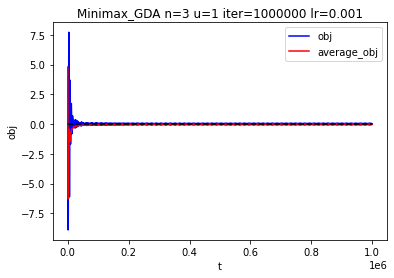

In [10]:
draw_obj_plt(result, None)

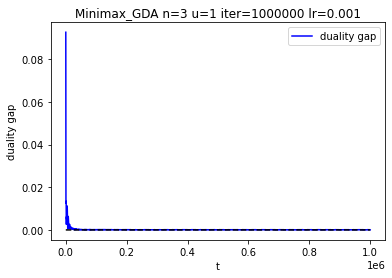

In [11]:
draw_duality_gap_plt(result, None)

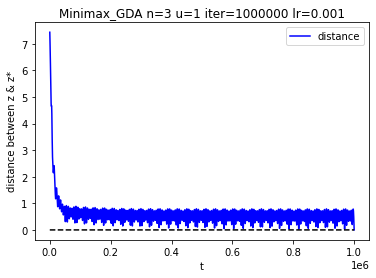

In [12]:
draw_distance_plt(result, result, None)